<img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> <div style="font-size: 25px">Data Science 2: Advanced Topics in Data Science</div>

## Lab 12a: DCGAN and Conditional DCGAN
**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2pt">

# 1. Introduction to Generative Adversarial Networks (GANs)

**What are GANs?**

As discussed in the lecture, Generative Adversarial Networks (GANs) are a powerful class of **generative models**. Instead of explicitly learning the probability distribution of the data (`p_model(x)`), they learn *implicitly* how to generate samples that *look like* they came from the real data distribution (`p_data(x)`).

They achieve this through an **adversarial game** between two neural networks:

1.  **Generator (G):** Takes random noise (from a latent space, often Gaussian) as input and tries to generate data (e.g., images, documents, etc.) that resembles the real training data. Its goal is to **fool** the Discriminator. (Think of the spammer trying to create emails that look legitimate).
2.  **Discriminator (D):** Takes either a real sample from the dataset or a fake sample from the Generator as input and tries to classify whether it's real or fake. Its goal is to **correctly identify** the fakes produced by the Generator. (Think of the spam filter trying to catch spam).

These two networks are trained together in a zero-sum game: the Generator gets better at creating fakes, forcing the Discriminator to get better at detecting them, which in turn pushes the Generator to improve further.

**Goal of this Notebook:**

In this notebook, we will build and train a simple **Deep Convolutional GAN (DCGAN)** using Keras/TensorFlow to generate images of clothing items based on the **Fashion-MNIST dataset**. We will follow the core principles outlined in the DCGAN paper and the training procedure discussed in class.

In [1]:
# Cell 1: Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import imageio # For creating GIF
import glob    # For finding image files

# Optional: Set a seed for reproducibility (helps during development/debugging)
# tf.random.set_seed(42)
# np.random.seed(42)

2025-04-25 01:29:08.975220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 01:29:08.975258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 01:29:08.975922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 01:29:08.980675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Parameters and Configuration

In [2]:
# Parameters

print("--- Setting Parameters ---")

# --- Data ---
BUFFER_SIZE = 60000  # Number of images to shuffle (use dataset size for full shuffle)
BATCH_SIZE = 256     # Number of images per batch during training
IMG_SHAPE = (28, 28, 1) # Shape of Fashion MNIST images (H, W, Channels)

# --- Model ---
LATENT_DIM = 100     # Dimensionality of the random noise vector (input to Generator)

# --- Training ---
EPOCHS = 50          # Number of times to iterate over the dataset
LEARNING_RATE = 0.0002 # Learning rate for Adam optimizer
ADAM_BETA_1 = 0.5    # Beta1 for Adam optimizer (common GAN practice, see DCGAN paper)

# --- Output ---
# Directory for saving generated images during training
IMAGE_SAVE_DIR = './gan_generated_images_fmnist'
if not os.path.exists(IMAGE_SAVE_DIR):
    os.makedirs(IMAGE_SAVE_DIR)
    print(f"Created directory: {IMAGE_SAVE_DIR}")
else:
    print(f"Output directory exists: {IMAGE_SAVE_DIR}")

print("Parameters set.")

--- Setting Parameters ---
Output directory exists: ./gan_generated_images_fmnist
Parameters set.


# 3. Load and Prepare the Dataset

We'll use the Fashion-MNIST dataset, which consists of 60,000 28x28 grayscale images of 10 clothing categories.

**Preprocessing Steps:**

1.  **Reshape:** Add a channel dimension (`1`) to the images, as required by convolutional layers in Keras.
2.  **Normalize:** Scale the pixel values from the original range `[0, 255]` to `[-1, 1]`. This is crucial because the Generator's final activation layer (`tanh`) outputs values in this range. Matching the input data range to the output range helps training stability.
3.  **Batch & Shuffle:** Convert the data into a `tf.data.Dataset` object for efficient processing. We shuffle the data to ensure the model doesn't learn spurious correlations based on the order and create batches.

--- Loading and Preparing Dataset ---
Reshaped images from (60000, 28, 28) to (60000, 28, 28, 1)
Normalized pixel values to range [-1, 1]


2025-04-25 01:29:25.166695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10356 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:3c:00.0, compute capability: 8.9


Created tf.data.Dataset with batch size 256

Sample real images from the dataset:


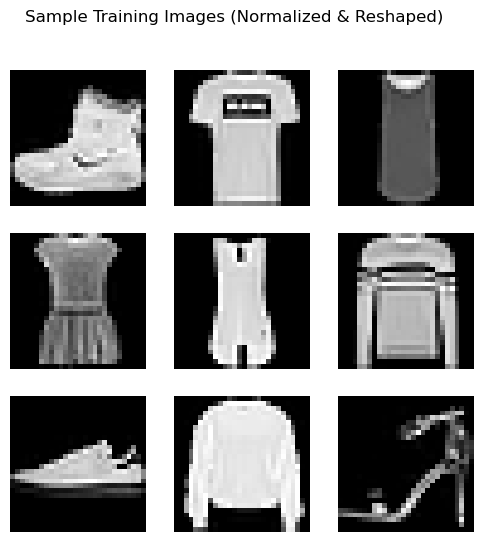

In [3]:
# Load and Prepare Dataset

print("--- Loading and Preparing Dataset ---")
# Load the Fashion MNIST dataset (we only need the training images for unconditional GAN)
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# --- Preprocess the images ---
# 1. Reshape to (num_images, height, width, channels)
original_shape = train_images.shape
train_images = train_images.reshape(original_shape[0], 28, 28, 1).astype('float32')
print(f"Reshaped images from {original_shape} to {train_images.shape}")

# 2. Normalize pixel values from [0, 255] to [-1, 1]
train_images = (train_images - 127.5) / 127.5
print(f"Normalized pixel values to range [-1, 1]")

# 3. Create a tf.data.Dataset for efficient batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE)
print(f"Created tf.data.Dataset with batch size {BATCH_SIZE}")

# --- Display some sample images ---
print("\nSample real images from the dataset:")
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # De-normalize for display: [-1, 1] -> [0, 1]
    display_img = train_images[i, :, :, 0] * 0.5 + 0.5
    plt.imshow(display_img, cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Training Images (Normalized & Reshaped)")
plt.show()

# 4. Build the Generator Model

The Generator's role is to take a random vector from the latent space (`z`) and transform it into an image that resembles the real data. For DCGANs, we typically:

*   Start with a Dense layer to project the latent vector (`LATENT_DIM`) into a higher-dimensional space suitable for reshaping.
*   Reshape this into a small spatial feature map (e.g., 7x7 with many channels).
*   Use `Conv2DTranspose` layers (also called "deconvolutions") to **upsample** the spatial dimensions (e.g., 7x7 -> 14x14 -> 28x28).
*   Use `BatchNormalization` after ConvTranspose layers (except the output layer) to stabilize training by normalizing activations.
*   Use `ReLU` or `LeakyReLU` as activation functions in intermediate layers.
*   Use `tanh` activation in the final layer to ensure the output pixel values are in the `[-1, 1]` range, matching our normalized input data.
*   Avoid fully connected layers beyond the initial projection.

In [4]:
# Build the Generator

def build_generator(latent_dim):
    """Builds the Generator model using Keras Sequential API."""
    model = keras.Sequential(name="Generator")

    # Input: Latent vector (latent_dim,)
    # Output: Image (28, 28, 1)

    # Layer 1: Project latent vector and reshape
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization()) # Stabilize gradients
    model.add(layers.LeakyReLU())         # Activation

    model.add(layers.Reshape((7, 7, 256))) # Reshape to 7x7x256 feature map

    # Layer 2: Upsample using Conv2DTranspose (7x7 -> 7x7, just changing channels here)
    # Note: strides=(1,1) with padding='same' doesn't change spatial size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 3: Upsample to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 4: Upsample to 28x28 (final image size)
    # Output channels = 1 (grayscale)
    # Activation = 'tanh' to output values in [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    print("--- Generator Summary ---")
    model.summary()
    return model

# Create the Generator instance
generator = build_generator(LATENT_DIM)

--- Generator Summary ---
Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (N

# 5. Build the Discriminator Model

The Discriminator acts as a binary classifier. It takes an image (either real or fake) as input and outputs a single scalar value (a logit) which can be used to indicate the probability that the input image is real. For DCGANs:

*   Input is an image (`IMG_SHAPE`).
*   Use `Conv2D` layers with strides > 1 to **downsample** the image, extracting features.
*   Use `LeakyReLU` activation (works well in GAN discriminators).
*   `Dropout` can be added to regularize and prevent the discriminator from becoming too strong too quickly.
*   We add `BatchNormalization` after the first conv block.
*   `Flatten` the final feature map.
*   A final `Dense(1)` layer outputs the single logit. **No activation function** is applied here, as we will use `from_logits=True` in our loss function for numerical stability.

In [5]:
# Build the Discriminator

def build_discriminator(img_shape):
    """Builds the Discriminator model using Keras Sequential API."""
    model = keras.Sequential(name="Discriminator")

    # Input: Image (28, 28, 1)
    # Output: Single logit value

    # Layer 1: Downsample 28x28 -> 14x14
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Regularization

    # Layer 2: Downsample 14x14 -> 7x7
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # Adding BatchNormalization based on reference implementation's standard D structure
    model.add(layers.BatchNormalization()) # <<< Added BN
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Layer 3: Flatten features
    model.add(layers.Flatten())

    # Layer 4: Output layer - single logit
    # No activation (using from_logits=True in loss)
    model.add(layers.Dense(1))

    print("\n--- Discriminator Summary ---")
    model.summary()
    return model

# Create the Discriminator instance
discriminator = build_discriminator(IMG_SHAPE)


--- Discriminator Summary ---
Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                      

# 6. Define Loss Functions and Optimizers

**Loss Functions:**

The core loss for GANs is typically **Binary Cross-Entropy (BCE)**.

*   **Discriminator Loss:** This has two parts:
    1.  Loss for real images: Measures how well D classifies real images as real (target label = 1). `BCE(D(real_images), 1)`
    2.  Loss for fake images: Measures how well D classifies fake images as fake (target label = 0). `BCE(D(fake_images), 0)`
    The total D loss is the sum of these two. D wants to **minimize** this combined loss (equivalent to maximizing the objective function V(G, D) from the lecture).
*   **Generator Loss:** Measures how well G fools D. We calculate the loss based on D's classification of the *fake* images, but G's goal is to make D classify them as *real* (target label = 1). `BCE(D(fake_images), 1)`. G wants to **minimize** this loss.

We use `tf.keras.losses.BinaryCrossentropy(from_logits=True)` because our Discriminator outputs raw logits, and this is more numerically stable than adding a Sigmoid layer and using `from_logits=False`.

**Optimizers:**

We use the `Adam` optimizer, which is standard for GANs. Following common practice (DCGAN paper), we set `beta_1=0.5`. We use separate optimizers for the Generator and Discriminator because they are updated independently.

In [6]:
# Define Loss and Optimizers

print("--- Defining Loss and Optimizers ---")
# Binary Cross Entropy loss function, configured to accept logits
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    # Loss comparing real image predictions to target of 1s
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Loss comparing fake image predictions to target of 0s
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(fake_output):
    # Loss comparing fake image predictions to target of 1s (Generator wants to fool D)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Separate Adam optimizers for Generator and Discriminator
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=ADAM_BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=ADAM_BETA_1)
print("Loss functions and Optimizers defined.")

--- Defining Loss and Optimizers ---
Loss functions and Optimizers defined.


# 7. Define the Training Step

This function encapsulates the operations performed in a single step of training, updating both the Discriminator and the Generator. We wrap it in `@tf.function` to compile it into a static TensorFlow graph, which significantly speeds up execution compared to running in eager mode line-by-line.

**Steps within `train_step`:**

1.  **Generate Noise:** Create a batch of random noise vectors (`LATENT_DIM`) as input for the Generator.
2.  **Record Operations (`tf.GradientTape`):** Use separate gradient tapes for the Generator and Discriminator to track the operations relevant to each model's loss calculation.
3.  **Generate Fake Images:** Pass the noise through the Generator (`generator(noise, training=True)`). `training=True` is important to ensure layers like Batch Normalization update their statistics correctly during training.
4.  **Get Discriminator Outputs:** Pass both the real `images` and the `generated_images` through the Discriminator (`discriminator(..., training=True)`). `training=True` enables layers like Dropout.
5.  **Calculate Losses:** Compute `gen_loss` and `disc_loss` using the functions defined earlier.
6.  **Calculate Gradients:** Use the tapes (`gen_tape`, `disc_tape`) to compute the gradients of each loss with respect to the trainable variables of the corresponding model.
7.  **Apply Gradients:** Use the respective optimizers (`gen_optimizer`, `disc_optimizer`) to update the model weights based on the calculated gradients.

In [7]:
# Define the Training Step Function

@tf.function # Compile function into a TensorFlow graph for speed
def train_step(images, generator, discriminator, gen_optimizer, disc_optimizer, latent_dim):
    """Performs a single training step (updates both D and G)."""

    # Use batch size dynamically from the input images tensor
    current_batch_size = tf.shape(images)[0]

    # Generate noise for the generator input
    noise = tf.random.normal([current_batch_size, latent_dim])

    # Use tf.GradientTape to automatically track gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Generate fake images from noise
        generated_images = generator(noise, training=True)

        # 2. Get Discriminator outputs for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 3. Calculate individual losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 4. Calculate gradients for Generator and Discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 5. Apply gradients to update weights
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return losses for monitoring
    return gen_loss, disc_loss

print("Training step function defined and decorated with @tf.function.")

Training step function defined and decorated with @tf.function.


# 8. Visualization Helper

To monitor the Generator's progress during training, it's helpful to visualize the images it produces. We create a function that:

*   Takes a fixed batch of noise vectors (`seed`) as input. This ensures we see how the output for the *same* input noise evolves over time.
*   Runs the Generator in **inference mode** (`training=False`) to generate images.
*   Arranges the generated images in a grid using Matplotlib.
*   Adds the current epoch number as a title.
*   Saves the grid as a PNG file. These PNGs can later be combined into an animated GIF.

In [8]:
# Helper Function for Visualization

# Create a fixed batch of noise vectors (latent variables)
# This allows us to visually track the Generator's improvement over time
# by always feeding it the same input noise for these samples.
NUM_EXAMPLES_TO_GENERATE = 16
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])
print(f"Created fixed noise seed for generating {NUM_EXAMPLES_TO_GENERATE} samples.")

def generate_and_save_images(model, epoch, test_input, save_dir):
    """Generates images, adds epoch title, saves as PNG grid."""
    # Ensure the model is in inference mode (effects layers like BN, Dropout)
    predictions = model(test_input, training=False)

    # Create a 4x4 grid plot
    fig = plt.figure(figsize=(4, 4))
    fig.suptitle(f"Epoch: {epoch}", fontsize=10) # Add epoch number as title

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # De-normalize [-1, 1] -> [0, 1] for display
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the plotted grid
    save_path = os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(save_path)
    plt.close(fig) # Close the figure to free up memory

print("Visualization helper function defined.")

Created fixed noise seed for generating 16 samples.
Visualization helper function defined.


# 9. Training Loop

This is the main loop where the training happens. It follows the standard GAN training algorithm (Intro Slide 56-57):

1.  **Iterate through Epochs:** Loop for the specified number of `EPOCHS`.
2.  **Iterate through Batches:** For each epoch, loop through the `train_dataset`.
3.  **Execute `train_step`:** Call the `train_step` function for each batch. This performs one update for both the Discriminator and the Generator based on the current batch of real images and generated fake images.
4.  **Track Losses:** Keep track of the generator and discriminator losses for each batch and calculate the average loss per epoch for monitoring.
5.  **Visualize Progress:** Periodically (e.g., after each epoch), call `generate_and_save_images` using the fixed `seed` noise to save sample outputs from the Generator.
6.  **Print Status:** Display the epoch number, time taken, and average losses.

In [9]:
# Training Loop Definition

def train(dataset, epochs, generator, discriminator, gen_optimizer, disc_optimizer, latent_dim, save_dir, seed):
    """Main training loop."""
    print("\n--- Starting Training ---")
    history = {'gen_loss': [], 'disc_loss': []} # Store average losses per epoch

    for epoch in range(epochs):
        start_time = time.time()
        epoch_gen_loss = tf.keras.metrics.Mean() # Keras utility to average losses
        epoch_disc_loss = tf.keras.metrics.Mean()

        # --- Train on Batches ---
        # `dataset` is the tf.data.Dataset providing batches
        # Use tqdm for a progress bar over the batches
        # from tqdm.auto import tqdm
        # for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
        for image_batch in dataset:
            # Perform one step of gradient update for both G and D
            g_loss, d_loss = train_step(image_batch, generator, discriminator,
                                        gen_optimizer, disc_optimizer, latent_dim)
            # Record losses from this step
            epoch_gen_loss.update_state(g_loss)
            epoch_disc_loss.update_state(d_loss)

        # --- End of Epoch ---
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss.result()
        avg_disc_loss = epoch_disc_loss.result()
        history['gen_loss'].append(avg_gen_loss.numpy())
        history['disc_loss'].append(avg_disc_loss.numpy())

        # Generate and save sample images using the fixed noise seed
        generate_and_save_images(generator, epoch + 1, seed, save_dir)

        # Print epoch summary
        print(f'Epoch {epoch + 1:04d}/{epochs} | Time: {time.time()-start_time:.2f} sec | '
              f'Gen Loss: {avg_gen_loss:.4f} | Disc Loss: {avg_disc_loss:.4f}')

    # --- End of Training ---
    # Generate one final grid after the last epoch
    generate_and_save_images(generator, epochs, seed, save_dir)
    print("\n--- Training Finished ---")
    return history

print("Main training function defined.")

Main training function defined.


In [10]:
# Execute Training

# This cell might take a while to run, especially for more epochs.

history = train(train_dataset, EPOCHS, generator, discriminator,
                generator_optimizer, discriminator_optimizer,
                LATENT_DIM, IMAGE_SAVE_DIR, seed)


--- Starting Training ---


2025-04-25 01:29:27.476983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-25 01:29:27.626999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-25 01:29:29.452597: I external/local_xla/xla/service/service.cc:168] XLA service 0x154263c39c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-25 01:29:29.452629: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-25 01:29:29.456455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745558969.523501   30163 device_compiler.h:186] Compiled cluster using XLA!  This li

Epoch 0001/50 | Time: 8.87 sec | Gen Loss: 0.8985 | Disc Loss: 1.4292
Epoch 0002/50 | Time: 3.08 sec | Gen Loss: 0.8889 | Disc Loss: 1.4558
Epoch 0003/50 | Time: 3.09 sec | Gen Loss: 1.0138 | Disc Loss: 1.2336
Epoch 0004/50 | Time: 3.25 sec | Gen Loss: 1.1362 | Disc Loss: 1.0881
Epoch 0005/50 | Time: 3.07 sec | Gen Loss: 1.1293 | Disc Loss: 1.1426
Epoch 0006/50 | Time: 3.08 sec | Gen Loss: 1.1198 | Disc Loss: 1.1153
Epoch 0007/50 | Time: 3.08 sec | Gen Loss: 1.1199 | Disc Loss: 1.1184
Epoch 0008/50 | Time: 3.07 sec | Gen Loss: 1.1309 | Disc Loss: 1.0999
Epoch 0009/50 | Time: 3.31 sec | Gen Loss: 1.1673 | Disc Loss: 1.0878
Epoch 0010/50 | Time: 3.08 sec | Gen Loss: 1.1699 | Disc Loss: 1.0700
Epoch 0011/50 | Time: 3.09 sec | Gen Loss: 1.1903 | Disc Loss: 1.0709
Epoch 0012/50 | Time: 3.09 sec | Gen Loss: 1.1747 | Disc Loss: 1.0820
Epoch 0013/50 | Time: 3.10 sec | Gen Loss: 1.1416 | Disc Loss: 1.1062
Epoch 0014/50 | Time: 3.09 sec | Gen Loss: 1.1069 | Disc Loss: 1.1281
Epoch 0015/50 | Time

# 10. Results and Visualization

**Loss Curves:**

Plotting the Generator and Discriminator loss over epochs can give some insight into the training dynamics. Ideally:

*   Both losses should decrease initially.
*   They should eventually reach some equilibrium, often fluctuating.
*   If D loss goes to zero and stays there, D is too strong, and G likely isn't learning.
*   If G loss goes very low while D loss stays high, G might be fooling D easily (perhaps D is too weak or G found an easy mode).

**Generated Image Quality:**

The most important evaluation for this simple example is visual inspection of the generated images saved during training and the final GIF. We look for:

*   **Fidelity:** Do the images look like realistic items of clothing? Are they sharp or blurry?
*   **Diversity:** Is the generator producing a variety of different clothing items, or is it stuck generating only one or a few types (mode collapse)?

--- Plotting Training Losses ---
Saved loss plot to: ./gan_generated_images_fmnist/training_loss_plot.png


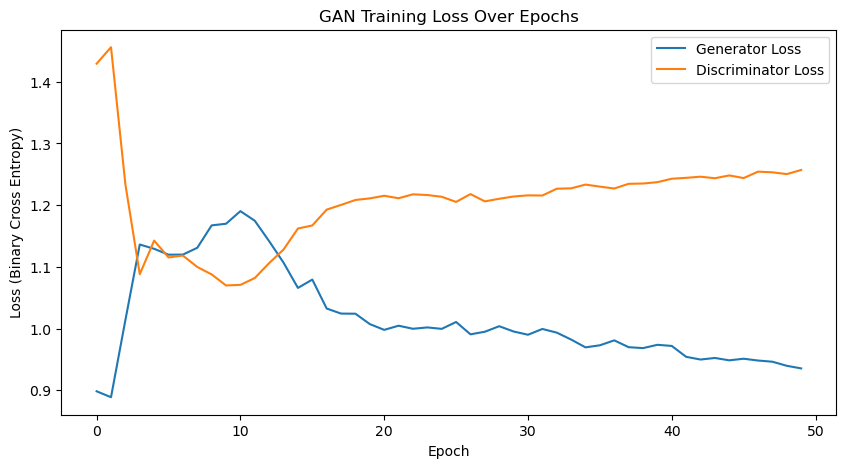

In [11]:
# Plot Loss History

print("--- Plotting Training Losses ---")
plt.figure(figsize=(10, 5))
plt.plot(history['gen_loss'], label='Generator Loss')
plt.plot(history['disc_loss'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.title('GAN Training Loss Over Epochs')
plt.legend()
# Save the plot
loss_plot_path = os.path.join(IMAGE_SAVE_DIR, 'training_loss_plot.png')
plt.savefig(loss_plot_path)
print(f"Saved loss plot to: {loss_plot_path}")
plt.show()

--- Creating Training Progress GIF ---
Reading images (using every 1 frame(s))...


/tmp/ipykernel_24293/2354157891.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Saving GIF (50 frames)...
Successfully created GIF: ./gan_generated_images_fmnist/fmnist_gan_training.gif


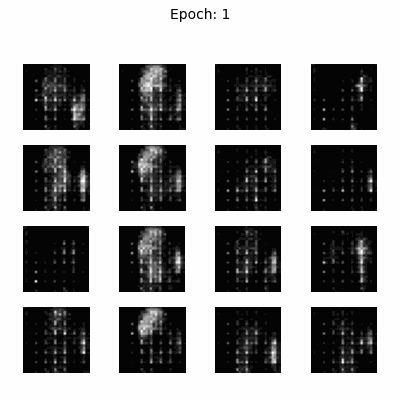

In [12]:
# Create Animated GIF

print(f"--- Creating Training Progress GIF ---")
GIF_FILENAME = 'fmnist_gan_training.gif'
GIF_PATH = os.path.join(IMAGE_SAVE_DIR, GIF_FILENAME)
FRAME_DURATION = 0.1 # Seconds per frame

# Find all saved epoch images, sorted correctly
filenames = sorted(glob.glob(os.path.join(IMAGE_SAVE_DIR, 'image_at_epoch_*.png')))

if not filenames:
    print(f"Error: No images found in {IMAGE_SAVE_DIR} matching 'image_at_epoch_*.png'")
else:
    images = []
    # Read only every Nth image to make GIF shorter/faster if many epochs were run
    # image_skip = max(1, len(filenames) // 100) # Example: keep ~100 frames
    image_skip = 1 # Use all frames for 50 epochs
    print(f"Reading images (using every {image_skip} frame(s))...")
    # Use tqdm for progress bar if loading many images
    # from tqdm.auto import tqdm
    # for filename in tqdm(filenames[::image_skip]):
    for filename in filenames: # Reading all frames based on image_skip=1
        images.append(imageio.imread(filename))

    # Save as an animated GIF, looping forever (loop=0)
    print(f"Saving GIF ({len(images)} frames)...")
    imageio.mimsave(GIF_PATH, images, duration=FRAME_DURATION, loop=0)
    print(f"Successfully created GIF: {GIF_PATH}")

    # Display GIF in notebook (might not work in all environments)
    from IPython.display import Image as IPImage
    try:
        display(IPImage(filename=GIF_PATH))
    except NameError:
        print("Could not display GIF inline (IPython not available or not in supported frontend).")

# 11. Evaluation (Brief Overview)

Evaluating GANs quantitatively is challenging because there's no single "ground truth" output for a given input noise vector. As discussed in the lecture (Eval Slides 3-5):

*   **Visual Inspection:** Still a primary method, especially during development. Do the images look good (fidelity) and varied (diversity)?
*   **Quantitative Metrics:** More rigorous methods exist but are complex to implement and interpret:
    *   **Inception Score (IS):** Measures fidelity (classifier confidence) and diversity (uniform class distribution) using a pre-trained Inception model. Higher is better. Prone to certain failure modes (Eval Slides 7-15).
    *   **Fréchet Inception Distance (FID):** Compares the statistics (mean and covariance) of features extracted from real and fake images using a pre-trained model (often Inception V3). Lower FID means the distributions are more similar (better). Considered more robust than IS (Eval Slides 19-25).
    *   **Other Metrics:** TSTR (Train Synthetic Test Real), Precision/Recall for distributions, etc.

For this introductory notebook, we rely primarily on visual inspection of the generated images and the loss curves. Implementing FID/IS would add significant complexity.

# 12. Conclusion

In this notebook, we built and trained a basic Deep Convolutional Generative Adversarial Network (DCGAN) on the Fashion-MNIST dataset using Keras/TensorFlow. We saw the two-player game between the Generator (trying to create realistic images from noise) and the Discriminator (trying to distinguish real from fake images). We visualized the Generator's progress over epochs and observed the characteristic adversarial training dynamics through the loss curves. This serves as a foundation for understanding more advanced GAN architectures and techniques.

# --- Part 2: Conditional Generation via cGAN ---

# 13. Motivation: Controlling GAN Output & Revisiting cGANs

In Part 1, our unconditional GAN generated random Fashion-MNIST items. Now, we want to control the generation by providing a class label (0-9).

Our goal is to implement a **Conditional GAN (cGAN)**. The basic idea is to feed the label `y` to both the Generator `G(z, y)` and Discriminator `D(x, y)`.

While simple cGAN implementations can sometimes struggle if the conditioning signal is weak or ignored by the Discriminator, certain architectural choices for injecting the condition can be very effective. We will adapt a cGAN architecture inspired by implementations known to achieve good results on Fashion-MNIST (like the one found at `github.com/qbxlvnf11/conditional-GAN`).

**Key Architectural Strategy:**

*   **Discriminator:** The label `y` will be embedded, reshaped into a map the same spatial size as the input image, and concatenated as an extra channel to the image `x` *before* the first convolution. `D` effectively sees `[ImageChannels, LabelChannel]`.
*   **Generator:** The noise `z` and label `y` will be processed separately initially, reshaped into small feature maps, and then concatenated along the channel axis before the main upsampling layers.

This approach ensures the condition `y` is deeply integrated into the processing of both networks.

In [13]:
# Parameters for Conditional GAN

print("--- Setting Parameters for Conditional GAN ---")

# --- Inherited/Reused Parameters ---
# LATENT_DIM, BUFFER_SIZE, BATCH_SIZE, IMG_SHAPE, LEARNING_RATE, ADAM_BETA_1
# Ensure these are available from Part 1

# --- Conditional Specific Parameters ---
NUM_CLASSES = 10     # 10 classes in Fashion MNIST
# Embedding Dim - Reference uses 50, but let's keep ours defined
EMBEDDING_DIM = 50   # Dimension for embedding the class label

C_EPOCHS = 75        # Number of epochs for cGAN training (adjust as needed)

# --- Output Directory ---
IMAGE_SAVE_DIR_CGAN = './gan_generated_images_fmnist_cgan' # New directory
if not os.path.exists(IMAGE_SAVE_DIR_CGAN):
    os.makedirs(IMAGE_SAVE_DIR_CGAN)
    print(f"Created directory: {IMAGE_SAVE_DIR_CGAN}")
else:
    print(f"Conditional output directory exists: {IMAGE_SAVE_DIR_CGAN}")

# --- Class Names (Required for visualization labels) ---
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Conditional GAN parameters confirmed/set.")

--- Setting Parameters for Conditional GAN ---
Conditional output directory exists: ./gan_generated_images_fmnist_cgan
Conditional GAN parameters confirmed/set.


# 14. Load and Prepare Dataset (with Labels)

We need the dataset yielding `(image, label)` pairs, just like we prepared for the (now omitted) AC-GAN attempt. We'll reuse the `train_dataset_ac` variable or reload if necessary. The preprocessing (reshape, normalize images; ensure integer labels) remains the same.

In [14]:
# Load and Prepare Dataset (with Labels)

print("--- Loading and Preparing Conditional Dataset ---")
# Load images AND labels again
(train_images_c, train_labels_c), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# --- Preprocess Images ---
original_shape_c = train_images_c.shape
train_images_c = train_images_c.reshape(original_shape_c[0], 28, 28, 1).astype('float32')
train_images_c = (train_images_c - 127.5) / 127.5 # Normalize to [-1, 1]
print(f"Preprocessed images: shape={train_images_c.shape}, range=[-1, 1]")

# --- Prepare Labels ---
train_labels_c = train_labels_c.astype('int32') # Ensure integer type
print(f"Labels shape: {train_labels_c.shape}, dtype={train_labels_c.dtype}")

# --- Create Conditional tf.data.Dataset ---
train_dataset_cgan = tf.data.Dataset.from_tensor_slices((train_images_c, train_labels_c))\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE)
print("Created conditional tf.data.Dataset yielding (images, labels).")

--- Loading and Preparing Conditional Dataset ---
Preprocessed images: shape=(60000, 28, 28, 1), range=[-1, 1]
Labels shape: (60000,), dtype=int32
Created conditional tf.data.Dataset yielding (images, labels).


# 15. Build the Conditional Generator (Reference Architecture)

We adapt the Generator using the Keras Functional API to incorporate the label conditioning based on "label as channel" strategy.

**Architecture:**
1.  **Inputs:** `noise_input` (`LATENT_DIM`) and `label_input` (integer).
2.  **Label Pathway:** Embed the label, project it with a `Dense` layer, and `Reshape` it into a `(7, 7, 1)` feature map.
3.  **Noise Pathway:** Project the noise with a `Dense` layer and `Reshape` it into a `(7, 7, 128)` feature map.
4.  **Concatenation:** Concatenate the label feature map and the noise feature map along the channel axis (`axis=-1`) to get a `(7, 7, 129)` combined map.
5.  **Upsampling:** Apply standard DCGAN upsampling blocks (`Conv2DTranspose`, `BatchNormalization`, `LeakyReLU`) to the combined map to reach the final `(28, 28, 1)` image output with `tanh` activation.

In [15]:
# Build the Conditional Generator (Reference Architecture)

def build_ref_c_generator(latent_dim, num_classes, embedding_dim):
    """Builds the cGAN Generator based on the reference notebook."""

    # --- Inputs ---
    noise_input = layers.Input(shape=(latent_dim,), name='NoiseInput')
    label_input = layers.Input(shape=(1,), dtype='int32', name='LabelInput')

    # --- Label Pathway ---
    # Embed label -> Project -> Reshape to spatial map (7x7x1)
    label_embedding = layers.Embedding(num_classes, embedding_dim, name='LabelEmbedding')(label_input)
    # Use Dense layer to project embedding before reshape
    label_dense = layers.Dense(7*7*1, name='LabelDense')(label_embedding) # Project to 7*7*1=49 units
    label_reshaped = layers.Reshape((7, 7, 1), name='LabelReshape')(label_dense)

    # --- Noise Pathway ---
    # Project noise -> Reshape to spatial map (7x7x128)
    noise_dense = layers.Dense(7*7*128, use_bias=False, name='NoiseDense')(noise_input)
    noise_reshaped = layers.Reshape((7, 7, 128), name='NoiseReshape')(noise_dense)
    noise_bn = layers.BatchNormalization(name='NoiseBN')(noise_reshaped) # BN after reshape
    noise_act = layers.LeakyReLU(name='NoiseLReLU')(noise_bn)

    # --- Merge Pathways ---
    # Concatenate along the channel dimension
    merged = layers.Concatenate(axis=-1, name='MergeLabelNoise')([noise_act, label_reshaped]) # Shape: (batch, 7, 7, 128+1=129)

    # --- Upsampling Body ---
    # ConvT -> BN -> LReLU
    # Block 1: 7x7 -> 14x14
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, name='G_ConvT1')(merged)
    up1 = layers.BatchNormalization(name='G_BN1')(up1)
    up1 = layers.LeakyReLU(name='G_LReLU1')(up1) # Shape: (batch, 14, 14, 128)

    # Block 2: 14x14 -> 28x28
    up2 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, name='G_ConvT2')(up1)
    up2 = layers.BatchNormalization(name='G_BN2')(up2)
    up2 = layers.LeakyReLU(name='G_LReLU2')(up2) # Shape: (batch, 28, 28, 64)

    # Output Block: 28x28 -> 28x28x1
    # Kernel 4, stride 1
    output_image = layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh', name='G_OutputConvT')(up2) # Shape: (batch, 28, 28, 1)

    # Define Model
    model = keras.Model(inputs=[noise_input, label_input], outputs=output_image, name="Reference_cGenerator")

    print("--- Conditional Generator (Reference Arch) Summary ---")
    model.summary()
    return model

# Create the Generator instance using the reference architecture
ref_c_generator = build_ref_c_generator(LATENT_DIM, NUM_CLASSES, EMBEDDING_DIM)

--- Conditional Generator (Reference Arch) Summary ---
Model: "Reference_cGenerator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 NoiseInput (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 NoiseDense (Dense)          (None, 6272)                 627200    ['NoiseInput[0][0]']          
                                                                                                  
 LabelInput (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 NoiseReshape (Reshape)      (None, 7, 7, 128)            0         ['NoiseDense[0][0]']          
                        

# 16. Build the Conditional Discriminator

We also adapt the Discriminator based on our strategy of adding the labels as a new channel.

**Architecture:**
1.  **Inputs:** `image_input` (`28x28x1`) and `label_input` (integer).
2.  **Label Pathway:** Embed the label, project it with `Dense`, and crucially, `Reshape` it into a `(28, 28, 1)` map.
3.  **Concatenation:** Concatenate the input image and the reshaped label map along the channel axis (`axis=-1`) to create a `(28, 28, 2)` input tensor.
4.  **Downsampling:** Apply standard DCGAN downsampling blocks (`Conv2D` with stride 2, `BatchNormalization`, `LeakyReLU`, `Dropout`) to the combined input.
5.  **Output:** `Flatten` the result and pass through a `Dense(1)` layer to get the final logit.

In [16]:
# Build the Conditional Discriminator

def build_ref_c_discriminator(img_shape, num_classes, embedding_dim):
    """Builds the cGAN Discriminator based on the reference notebook."""

    # --- Inputs ---
    image_input = layers.Input(shape=img_shape, name='ImageInput') # e.g., (28, 28, 1)
    label_input = layers.Input(shape=(1,), dtype='int32', name='LabelInput')

    # --- Label Pathway ---
    # Embed label -> Project -> Reshape to match image spatial dims (28x28x1)
    label_embedding = layers.Embedding(num_classes, embedding_dim, name='LabelEmbedding')(label_input)
    # Project embedding to match total pixels H*W*1
    num_pixels = img_shape[0] * img_shape[1]
    label_dense = layers.Dense(num_pixels, name='LabelDense')(label_embedding)
    label_reshaped = layers.Reshape((img_shape[0], img_shape[1], 1), name='LabelReshape')(label_dense) # Shape: (batch, 28, 28, 1)

    # --- Merge Pathways ---
    # Concatenate image and reshaped label along the channel axis
    merged = layers.Concatenate(axis=-1, name='MergeImageLabel')([image_input, label_reshaped]) # Shape: (batch, 28, 28, 1+1=2)

    # --- Downsampling Body ---
    # Using Conv -> LReLU -> BN -> Dropout pattern mostly
    # Block 1: 28x28 -> 14x14
    d1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, name='D_Conv1')(merged) # Input channels = 2
    d1 = layers.LeakyReLU(0.2, name='D_LReLU1')(d1)
    # Reference repo uses BN after first block (!?)
    d1 = layers.BatchNormalization(name='D_BN1')(d1)
    d1 = layers.Dropout(0.3, name='D_Drop1')(d1)

    # Block 2: 14x14 -> 7x7
    d2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, name='D_Conv2')(d1)
    d2 = layers.BatchNormalization(name='D_BN2')(d2)
    d2 = layers.LeakyReLU(0.2, name='D_LReLU2')(d2)
    d2 = layers.Dropout(0.3, name='D_Drop2')(d2)

    # Block 3: We could use one more block 7x7 -> 4x4 (approx)
    # d3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, name='D_Conv3')(d2)
    # d3 = layers.BatchNormalization(name='D_BN3')(d3)
    # d3 = layers.LeakyReLU(0.2, name='D_LReLU3')(d3)
    # d3 = layers.Dropout(0.3, name='D_Drop3')(d3)
    # Let's stick to two conv blocks for simplicity first, flatten d2

    # --- Output ---
    flat = layers.Flatten(name='D_Flatten')(d2) # Flatten features from last conv block
    output_logit = layers.Dense(1, name='D_OutputLogit')(flat) # Final logit output

    # Define Model
    model = keras.Model(inputs=[image_input, label_input], outputs=output_logit, name="Reference_cDiscriminator")

    print("\n--- Conditional Discriminator (Reference Arch) Summary ---")
    model.summary()
    return model

# Create the Discriminator instance using the reference architecture
ref_c_discriminator = build_ref_c_discriminator(IMG_SHAPE, NUM_CLASSES, EMBEDDING_DIM)


--- Conditional Discriminator (Reference Arch) Summary ---
Model: "Reference_cDiscriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LabelInput (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 LabelEmbedding (Embedding)  (None, 1, 50)                500       ['LabelInput[0][0]']          
                                                                                                  
 LabelDense (Dense)          (None, 1, 784)               39984     ['LabelEmbedding[0][0]']      
                                                                                                  
 ImageInput (InputLayer)     [(None, 28, 28, 1)]          0         []                            
               

# 17. Define cGAN Loss Functions and Optimizers

We use the standard cGAN loss functions, which are identical to the unconditional GAN case. The conditioning is handled by the model architectures and inputs.

In [17]:
# Define cGAN Loss Functions and Optimizers
print("--- Defining cGAN Losses and Optimizers ---")

# Reuse the BinaryCrossentropy loss from the unconditional GAN section
try:
    cross_entropy # Check if it exists
    print("Reusing BinaryCrossentropy loss function.")
except NameError:
    print("Defining BinaryCrossentropy loss function.")
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

try:
    discriminator_loss
    generator_loss
    print("Reusing discriminator_loss and generator_loss functions.")
except NameError:
    print("ERROR: Loss functions not defined. They're defined earlier in the notebook.")

# Create NEW optimizer instances for the cGAN models
ref_c_generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=ADAM_BETA_1)
ref_c_discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=ADAM_BETA_1)
print("Optimizers for reference cGAN models defined.")

--- Defining cGAN Losses and Optimizers ---
Reusing BinaryCrossentropy loss function.
Reusing discriminator_loss and generator_loss functions.
Optimizers for reference cGAN models defined.


# 18. Define the Conditional Training Step (for Reference cGAN)

This training step function is very similar to the one we would have used for our previous cGAN attempt. It takes images and labels, generates fake images conditioned on labels, gets predictions from the discriminator for real/fake pairs (also conditioned on labels), calculates the standard cGAN losses, and applies gradients.

In [18]:
# Define the Conditional Training Step

@tf.function
def conditional_train_step(images, labels, generator, discriminator, gen_optimizer, disc_optimizer, latent_dim):
    """Performs a single conditional training step."""

    current_batch_size = tf.shape(images)[0]
    noise = tf.random.normal([current_batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images conditioned on the labels from the real batch
        # Generator takes a list of inputs [noise, label]
        generated_images = generator([noise, labels], training=True)

        # Get Discriminator outputs for real images paired WITH their labels
        real_output = discriminator([images, labels], training=True)
        # Get Discriminator outputs for fake images paired WITH the labels they were conditioned on
        fake_output = discriminator([generated_images, labels], training=True)

        # Calculate standard cGAN losses
        gen_loss = generator_loss(fake_output)          # G wants D to output 1 for fakes
        disc_loss = discriminator_loss(real_output, fake_output) # D wants D(real)=1, D(fake)=0

    # Calculate and apply gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss # Return only the main losses

print("Conditional training step function defined.")

Conditional training step function defined.


# 19. Conditional Visualization Helper

To visualize the output of our Conditional GAN, we need a function that generates images for each specific class label (0-9) using a fixed set of noise vectors. This allows us to see if the Generator is correctly producing, for example, 'T-shirts' when given label 0 and 'Ankle boots' when given label 9.

This function will:
*   Take the Generator, current epoch, fixed noise, fixed labels, save directory, and class information as input.
*   Generate images using the Generator in inference mode (`training=False`).
*   Arrange the images in a grid where each row corresponds to a class.
*   Add the epoch number and class names to the plot for clarity.
*   Save the grid as a PNG file.

In [19]:
# Define Conditional Visualization Helper

# Create fixed noise and labels for consistent visualization across epochs
# Ensure these variables are defined using parameters from Cell 13
num_examples_per_class = 8 # How many samples per class in the grid
try:
    # Check if already defined (e.g., if user experimented and didn't restart fully)
    fixed_noise
    fixed_labels
    print("Reusing existing fixed_noise and fixed_labels for visualization.")
except NameError:
    print("Defining fixed_noise and fixed_labels for visualization.")
    fixed_noise_base = tf.random.normal([num_examples_per_class, LATENT_DIM])
    fixed_noise = tf.tile(fixed_noise_base, [NUM_CLASSES, 1]) # Shape: (NUM_CLASSES * num_examples_per_class, LATENT_DIM)
    fixed_labels = tf.range(0, NUM_CLASSES, dtype=tf.int32) # Labels 0 to 9
    fixed_labels = tf.repeat(fixed_labels, repeats=num_examples_per_class) # Shape: (NUM_CLASSES * num_examples_per_class,)

print(f"Fixed noise shape: {fixed_noise.shape}")
print(f"Fixed labels shape: {fixed_labels.shape}")

def generate_and_save_images_conditional(model, epoch, test_noise, test_labels, save_dir, num_classes, num_examples_per_class, class_names):
    """Generates conditional images and saves them as a grid with class rows."""
    # Generate images in inference mode
    # Ensure the model takes a list of inputs [noise, label]
    predictions = model([test_noise, test_labels], training=False)

    num_rows = num_classes
    num_cols = num_examples_per_class
    fig = plt.figure(figsize=(num_cols * 0.8, num_rows * 0.8)) # Adjust size as needed
    fig.suptitle(f"Epoch: {epoch}", fontsize=10)

    for i in range(predictions.shape[0]):
        plt.subplot(num_rows, num_cols, i + 1)
        # De-normalize [-1, 1] -> [0, 1] for display
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
        # Add class name label to the start of each row
        if i % num_cols == 0:
             # Ensure class_names list is available in the scope
             plt.text(-10, 14, class_names[i // num_cols], ha='right', va='center', fontsize=8, rotation=90)

    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95]) # Adjust padding for labels
    # Use a distinct filename prefix for clarity if comparing multiple GAN types later
    save_path = os.path.join(save_dir, f'ref_cgan_image_at_epoch_{epoch:04d}.png')
    plt.savefig(save_path)
    plt.close(fig) # Close the plot figure

print("Conditional visualization helper function 'generate_and_save_images_conditional' defined.")

Defining fixed_noise and fixed_labels for visualization.
Fixed noise shape: (80, 100)
Fixed labels shape: (80,)
Conditional visualization helper function 'generate_and_save_images_conditional' defined.


# 20. Conditional Training Loop (Reference cGAN)

This loop runs the training using the reference cGAN architecture and the standard conditional training step.

In [20]:
# Define Conditional Training Loop

def train_conditional_ref(dataset, epochs, generator, discriminator, gen_optimizer, disc_optimizer, latent_dim, save_dir, num_classes, num_examples_per_class, fixed_noise, fixed_labels, class_names):
    """Main training loop for the reference cGAN architecture."""
    print("\n--- Starting Reference cGAN Training ---")
    history = {'gen_loss': [], 'disc_loss': []}

    for epoch in range(epochs):
        start_time = time.time()
        epoch_gen_loss = tf.keras.metrics.Mean()
        epoch_disc_loss = tf.keras.metrics.Mean()

        # Iterate over batches (image_batch, label_batch)
        # from tqdm.auto import tqdm
        # for image_batch, label_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
        for image_batch, label_batch in dataset:
            # Use the standard conditional train step
            g_loss, d_loss = conditional_train_step( # Ensure this step function is defined above (Cell 18)
                image_batch, label_batch, generator, discriminator,
                gen_optimizer, disc_optimizer, latent_dim
            )
            epoch_gen_loss.update_state(g_loss)
            epoch_disc_loss.update_state(d_loss)

        # --- End of Epoch ---
        avg_gen_loss = epoch_gen_loss.result()
        avg_disc_loss = epoch_disc_loss.result()
        history['gen_loss'].append(avg_gen_loss.numpy())
        history['disc_loss'].append(avg_disc_loss.numpy())

        # Produce and save conditional sample images using the helper function
        # Ensure generate_and_save_images_conditional is defined (Cell 19)
        try:
            generate_and_save_images_conditional(generator, epoch + 1, fixed_noise, fixed_labels, save_dir, num_classes, num_examples_per_class, class_names)
        except NameError:
             print(f"Epoch {epoch+1}: generate_and_save_images_conditional function not defined. Skipping visualization.")
        except Exception as e:
             print(f"Epoch {epoch+1}: Error during visualization - {e}")


        # Print progress
        print(f'Epoch {epoch + 1:04d}/{epochs} | Time: {time.time()-start_time:.2f} sec | '
              f'Gen Loss: {avg_gen_loss:.4f} | Disc Loss: {avg_disc_loss:.4f}')

    # --- End of Training ---
    # Generate one final grid after training
    try:
        generate_and_save_images_conditional(generator, epochs, fixed_noise, fixed_labels, save_dir, num_classes, num_examples_per_class, class_names)
    except NameError:
        print("Final visualization skipped: function not defined.")
    except Exception as e:
        print(f"Error during final visualization - {e}")

    print("\n--- Reference cGAN Training Finished ---")
    return history

print("Reference cGAN training function defined.")

Reference cGAN training function defined.


In [21]:
# Execute Reference cGAN Training

ref_c_history = train_conditional_ref(
    train_dataset_cgan, # Use the dataset yielding (images, labels)
    C_EPOCHS,
    ref_c_generator,
    ref_c_discriminator,
    ref_c_generator_optimizer,
    ref_c_discriminator_optimizer,
    LATENT_DIM,
    IMAGE_SAVE_DIR_CGAN, # Save to the cGAN directory
    NUM_CLASSES,
    num_examples_per_class, # For visualization
    fixed_noise,             # For visualization
    fixed_labels,            # For visualization
    class_names              # For visualization
)


--- Starting Reference cGAN Training ---


2025-04-25 01:32:13.082456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inReference_cDiscriminator/D_Drop1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 0001/75 | Time: 13.89 sec | Gen Loss: 1.1703 | Disc Loss: 1.1500
Epoch 0002/75 | Time: 5.94 sec | Gen Loss: 1.6614 | Disc Loss: 0.7557
Epoch 0003/75 | Time: 6.18 sec | Gen Loss: 2.1948 | Disc Loss: 0.5363
Epoch 0004/75 | Time: 6.28 sec | Gen Loss: 2.2799 | Disc Loss: 0.5514
Epoch 0005/75 | Time: 5.97 sec | Gen Loss: 1.9681 | Disc Loss: 0.6236
Epoch 0006/75 | Time: 6.40 sec | Gen Loss: 1.9735 | Disc Loss: 0.6335
Epoch 0007/75 | Time: 5.95 sec | Gen Loss: 1.8819 | Disc Loss: 0.7403
Epoch 0008/75 | Time: 6.53 sec | Gen Loss: 1.6803 | Disc Loss: 0.8658
Epoch 0009/75 | Time: 5.96 sec | Gen Loss: 1.6122 | Disc Loss: 0.8673
Epoch 0010/75 | Time: 5.99 sec | Gen Loss: 1.5799 | Disc Loss: 0.8890
Epoch 0011/75 | Time: 6.67 sec | Gen Loss: 1.5275 | Disc Loss: 0.9327
Epoch 0012/75 | Time: 5.95 sec | Gen Loss: 1.4872 | Disc Loss: 0.9503
Epoch 0013/75 | Time: 5.95 sec | Gen Loss: 1.4640 | Disc Loss: 0.9657
Epoch 0014/75 | Time: 6.85 sec | Gen Loss: 1.4461 | Disc Loss: 0.9711
Epoch 0015/75 | Tim

# 21. Reference cGAN Results

**Loss Curves & Generated Images:**

We examine the loss curves and the generated image grids (and GIF) produced by this reference cGAN architecture. Compare these results to any previous attempts (like the initial unconditional GAN or potentially failed simple cGANs/AC-GANs).

*   Does the loss curve show reasonable convergence or stability?
*   Most importantly, do the generated images in the grid show clear conditioning? Does each row correspond well to the intended class label? Is there reasonable diversity within each class?

This architecture, particularly the label injection method, often proves more effective for conditional generation on image datasets like Fashion-MNIST.

--- Plotting Reference cGAN Training Losses ---
Saved reference cGAN loss plot to: ./gan_generated_images_fmnist_cgan/ref_cgan_training_loss_plot.png


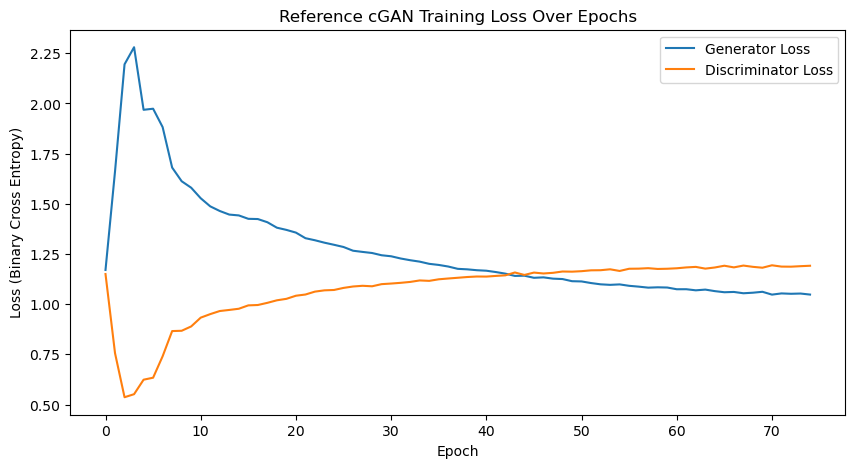

In [22]:
# Plot Reference cGAN Loss History

print("--- Plotting Reference cGAN Training Losses ---")
plt.figure(figsize=(10, 5))
plt.plot(ref_c_history['gen_loss'], label='Generator Loss')
plt.plot(ref_c_history['disc_loss'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.title('Reference cGAN Training Loss Over Epochs')
plt.legend()
# Save the plot
ref_c_loss_plot_path = os.path.join(IMAGE_SAVE_DIR_CGAN, 'ref_cgan_training_loss_plot.png')
plt.savefig(ref_c_loss_plot_path)
print(f"Saved reference cGAN loss plot to: {ref_c_loss_plot_path}")
plt.show()

--- Creating Reference cGAN Training Progress GIF ---
Reading reference cGAN images (using every 1 frame(s))...


/tmp/ipykernel_24293/624788844.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ref_c_images.append(imageio.imread(filename))


Saving Reference cGAN GIF (44 frames)...
Successfully created Reference cGAN GIF: ./gan_generated_images_fmnist_cgan/fmnist_ref_cgan_training.gif


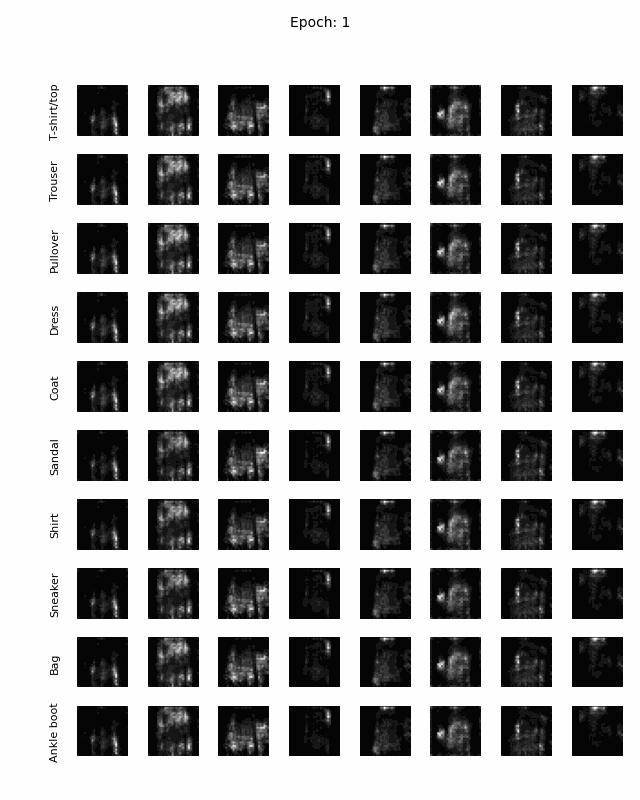

In [23]:
# Create Reference cGAN Animated GIF

print(f"--- Creating Reference cGAN Training Progress GIF ---")
REF_C_GIF_FILENAME = 'fmnist_ref_cgan_training.gif'
REF_C_GIF_PATH = os.path.join(IMAGE_SAVE_DIR_CGAN, REF_C_GIF_FILENAME)
REF_C_FRAME_DURATION = 0.1 # Seconds per frame

# Find all saved reference cGAN epoch images
ref_c_filenames = sorted(glob.glob(os.path.join(IMAGE_SAVE_DIR_CGAN, 'acgan_image_at_epoch_*.png'))) # Adjust pattern if needed

if not ref_c_filenames:
    print(f"Error: No images found in {IMAGE_SAVE_DIR_CGAN} matching pattern.")
else:
    ref_c_images = []
    image_skip = 1 # Use all frames
    print(f"Reading reference cGAN images (using every {image_skip} frame(s))...")
    for filename in ref_c_filenames[::image_skip]:
        ref_c_images.append(imageio.imread(filename))

    print(f"Saving Reference cGAN GIF ({len(ref_c_images)} frames)...")
    imageio.mimsave(REF_C_GIF_PATH, ref_c_images, duration=REF_C_FRAME_DURATION, loop=0)
    print(f"Successfully created Reference cGAN GIF: {REF_C_GIF_PATH}")

    # Display GIF
    from IPython.display import Image as IPImage
    try:
        display(IPImage(filename=REF_C_GIF_PATH))
    except NameError:
        print("Could not display GIF inline.")

# 22. Reference cGAN Conclusion

By adopting the specific architectural choices for label injection from a working reference implementation, we aimed to overcome the conditioning failures potentially observed with simpler cGAN or AC-GAN approaches. This demonstrates that while the core GAN loss functions might remain the same, the *way* conditioning information is integrated into the network flow is critical for successful conditional generation. Visual inspection of the results from this reference architecture should hopefully confirm its effectiveness on the Fashion-MNIST dataset.